In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import mlflow
import mlflow.sklearn

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load data
df = pd.read_csv("completed_Apples_stock price dataset.csv" )
df

,Unnamed: 0.1,Unnamed: 0,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment,date,time
0,0,4,2010-01-01 04:00:00,98.983464,8002.448861,2997.154387,4.270254,4.942654,1.929987,-0.223077,2010-01-01,04:00:00
1,1,5,2010-01-01 05:00:00,99.022103,8011.832789,3004.510779,2.321292,4.095568,1.664753,-0.828119,2010-01-01,05:00:00
2,2,6,2010-01-01 06:00:00,108.127409,8028.157784,3010.735533,2.626140,5.447153,2.995546,-0.813849,2010-01-01,06:00:00
3,3,7,2010-01-01 07:00:00,104.107075,8027.722289,3015.504909,4.056720,3.377880,3.276263,0.002849,2010-01-01,07:00:00
4,4,8,2010-01-01 08:00:00,97.961085,8029.541811,3020.187389,2.099831,4.815785,1.761161,-0.634609,2010-01-01,08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
50587,50587,99976,2021-05-28 16:00:00,488.004936,507912.456960,200756.680777,3.107003,3.830638,2.443950,-0.626843,2021-05-28,16:00:00
50588,50588,99977,2021-05-28 17:00:00,501.413780,507914.215983,200770.582677,3.785128,6.567227,0.662596,-0.013764,2021-05-28,17:00:00
50589,50589,99978,2021-05-28 18:00:00,492.627037,507927.121232,200775.369524,2.392459,6.589893,2.519469,0.207107,2021-05-28,18:00:00
50590,50590,99979,2021-05-28 19:00:00,504.385488,507928.596882,200774.361821,3.168374,3.334340,1.567604,-0.379527,2021-05-28,19:00:00


In [5]:
import json
try:
    with open("model_scores.json", "r") as f:
            final_scores = json.load(f)
except FileNotFoundError: 
    final_scores = {}   # start fresh if file doesn't exist

In [6]:
endog_vars = ['stock_price',  "sp500_index"]
y = df[endog_vars]
exog_vars = ["nasdaq_index",  "inflation_rate", "unemployment_rate", "interest_rate", "market_sentiment"]
x = df[exog_vars]

In [7]:
# Data Splitting: 80% train, 20% test
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]
train_exog, test_exog = x[:train_size], x[train_size:]
train_size, train.shape, test.shape, train_exog.shape, test_exog.shape

(40473, (40473, 2), (10119, 2), (40473, 5), (10119, 5))

In [8]:
train_diff = train.diff().dropna()
test_diff  = test.diff().dropna()

train_exog_diff = train_exog.diff().dropna()
test_exog_diff  = test_exog.diff().dropna()

train_diff.shape, test_diff.shape, train_exog_diff.shape, test_exog_diff.shape
#((40472, 2), (10118, 2), (40472, 5), (10118, 5))

((40472, 2), (10118, 2), (40472, 5), (10118, 5))

In [9]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0], "p-value:", result[1])

# Example check
check_stationarity(train_diff.iloc[:,0])

ADF Statistic: -44.896961285252864 p-value: 0.0


In [10]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error

In [11]:
#train_diff.index, train_exog_diff.index

In [12]:
best_config = None
best_aic = float("inf")
best_rmse = float("inf")
best_r2 = float("inf")
best_mae = float("inf")
lag_orders = range(8, 11)   # test lags from 1 to 10

for lag in lag_orders:
    
    # Fit VAR model
    model = VAR(endog=train_diff, exog=train_exog_diff)
    results = model.fit(maxlags=lag)   # we can tune lag order
    
    # Forecast 
    lag_order = results.k_ar
    forecast_input = train_diff.values[-lag_order:]
    forecast = results.forecast(y=forecast_input, steps=len(test_diff), exog_future=test_exog_diff.values)

    # Convert forecast to DataFrame
    forecast_df = pd.DataFrame(forecast, index=test_diff.index, columns=endog_vars)
    # Start from the last observed value
    last_value = train.iloc[-1].values
    forecast_values = []
    
    for step in range(len(forecast_df)):
        # Add the forecasted difference to the last value
        next_value = last_value + forecast_df.iloc[step].values
        forecast_values.append(next_value)
        last_value = next_value  # update for next step
    
    forecast_final = pd.DataFrame(forecast, index=test_diff.index, columns=endog_vars)
    
    # Evaluation metrics 
    AIC = results.aic
    BIC = results.bic
    RMSE = root_mean_squared_error(test_diff, forecast)
    MAE = mean_absolute_error(test_diff, forecast)
    r2   = r2_score(test_diff, forecast)

    # --- Plot comparison ---
    plt.figure(figsize=(12,6))
    plt.plot(train_diff.index, train_diff, label="Train Data")
    plt.plot(test_diff.index, test_diff, label="Test Data", color="black")    
    plt.plot(test_diff.index, forecast, label="VAR Forecast", color="red")
    plt.legend()
    plt.title(f" VAR Forecast ")
    plt.savefig(f"VAR_{lag}_{AIC}_{r2}.png") 
    plt.close()

    with mlflow.start_run(run_name=f"VAR_{lag}"):
        mlflow.log_param("lag", lag)        
        mlflow.log_metric("AIC", float(AIC))
        mlflow.log_metric("BIC", float(BIC))
        mlflow.log_metric("RMSE", float(RMSE))
        mlflow.log_metric("MAE", float(MAE))
        mlflow.log_metric("r2Square", float(r2))
        mlflow.log_artifact(f"VAR_{lag}_{AIC}_{r2}.png") 
        mlflow.sklearn.log_model(model, name="VAR")
    
       # Track best model
    if AIC < best_aic:
        best_aic = AIC
        best_rmse = RMSE
        best_r2 = r2
        best_mae = MAE
        best_config = (lag)
        
    print(f"Lag:{lag}  AIC:{AIC} BIC:{BIC} RMSE:{RMSE} r2:{r2} MAE:{MAE} \n")
    #print(lag, AIC, BIC, RMSE, r2)

C:\Users\YOGITA\miniconda3\envs\DSENV\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
2026/01/31 10:26:00 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/31 10:26:00 INFO mlflow.store.db.utils: Updating database tables
2026/01/31 10:26:00 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/31 10:26:00 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/31 10:26:01 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/31 10:26:01 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/31 10:26:02 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git e

Lag:8  AIC:8.153396324794947 BIC:8.162756728873436 RMSE:8.864062341697457 r2:0.2958242633512389 MAE:5.790287344510146 



C:\Users\YOGITA\miniconda3\envs\DSENV\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Lag:9  AIC:8.144031045806344 BIC:8.154242618755788 RMSE:8.864049743755508 r2:0.29583384223501674 MAE:5.790444869900504 



C:\Users\YOGITA\miniconda3\envs\DSENV\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Lag:10  AIC:8.136704709150903 BIC:8.147767488156735 RMSE:8.863711468580405 r2:0.2958864215888542 MAE:5.789969595755908 



In [13]:
print("\nBest VAR configuration:")
print(f"Lag={best_config} | AIC={best_aic:.2f}, RMSE={best_rmse:.2f}")
final_scores["VAR"] = {"AIC": best_aic, "RMSE": best_rmse, "R2": best_r2, "MAE": best_mae }


Best VAR configuration:
Lag=10 | AIC=8.14, RMSE=8.86


C:\Users\YOGITA\miniconda3\envs\DSENV\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


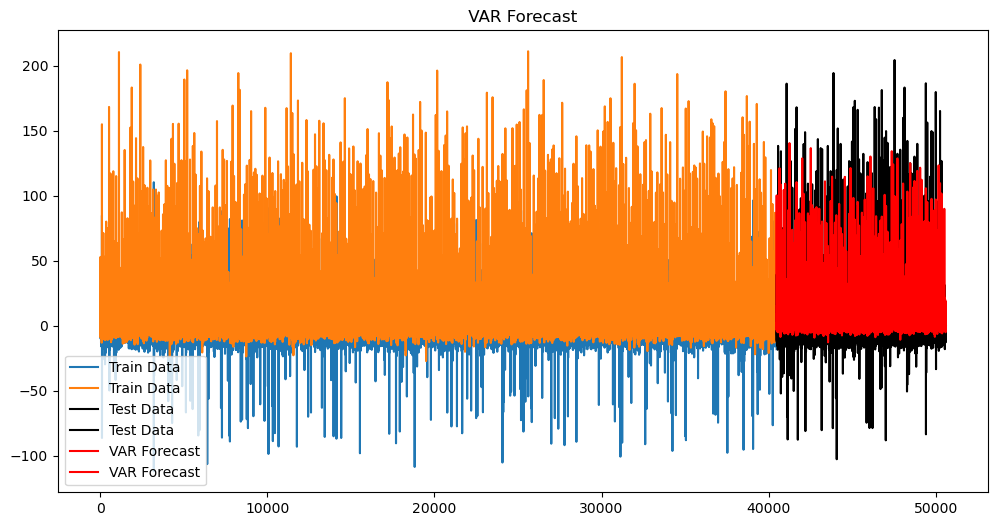

In [14]:
model = VAR(endog=train_diff, exog=train_exog_diff)
results = model.fit(maxlags=best_config) 
#sarima_forecast = sarima_model_fit.forecast(steps=len(test), exog=test_exog)
# Forecast 
lag_order = results.k_ar
forecast_input = train_diff.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=len(test_diff), exog_future=test_exog_diff.values)

# --- Plot comparison ---
plt.figure(figsize=(12,6))
plt.plot(train_diff.index, train_diff, label="Train Data")
plt.plot(test_diff.index, test_diff, label="Test Data", color="black")    
plt.plot(test_diff.index, forecast, label="VAR Forecast", color="red")
plt.legend()
plt.title(f" VAR Forecast ")
#plt.savefig(f"VAR_{order}_{AIC}_{r2}.png")     
plt.show()
plt.close() 

 Best choice according to goal:
 forecasting accuracy:  Lag 10 is best as it shows lowest RMSE, AIC/BIC
 interpretability and varience explanation:  Lag 1-2 are better as it shows higher R2, simpler model


In [15]:
# 11.124705291397635 11.127683146485506 1108.808648647343 0.487667414906062

In [16]:
import json

# Save model score
with open("model_scores.json", "w") as f:
    json.dump(final_scores, f, indent=4)

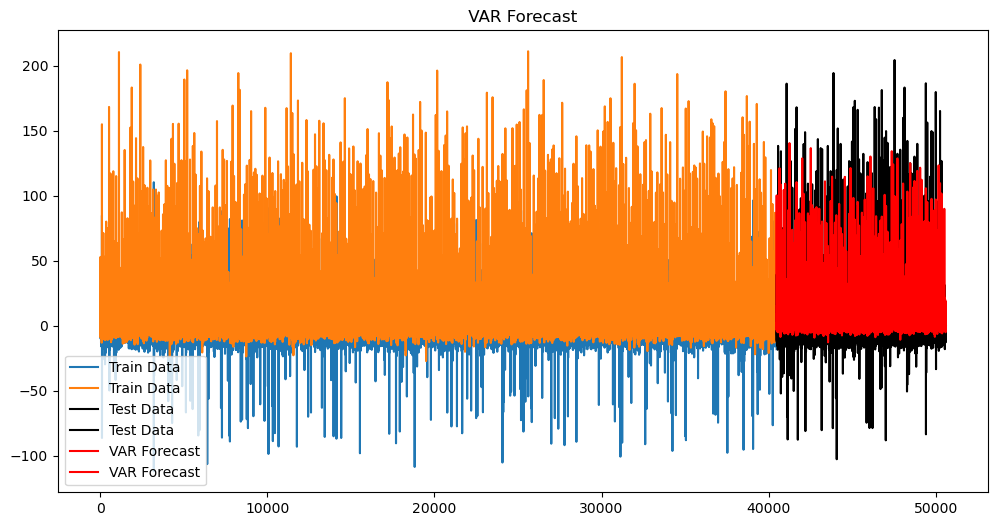

In [18]:
# --- Plot comparison ---
plt.figure(figsize=(12,6))
plt.plot(train_diff.index, train_diff, label="Train Data")
plt.plot(test_diff.index, test_diff, label="Test Data", color="black")    
plt.plot(test_diff.index, forecast, label="VAR Forecast", color="red")
plt.legend()
plt.title(f" VAR Forecast ")
plt.savefig(f"VAR.png")     
plt.show()
plt.close()